In [1]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import random
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from tqdm import trange

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('use: ',device)

use:  cuda


In [3]:
batch_size = 256

transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='../data', train=True, download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset,batch_size=batch_size, shuffle=True, drop_last=True)
testset = torchvision.datasets.CIFAR10(root='../data', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset,batch_size=batch_size, shuffle=False, drop_last=True)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [4]:
cfg = {
    'VGG11': [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'VGG13': [64, 64, 'M', 128, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'VGG16': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M'],
    'VGG19': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512, 512, 512, 'M', 512, 512, 512, 512, 'M'],
}

In [ ]:
def init_weights(m):
  classname = m.__class__.__name__
  if classname.find('Linear') != -1:
    #nn.init.xavier_uniform(m.weight)
    if type(m.bias) != type(None):
        nn.init.constant_(m.bias.data, 0)
   
  elif classname.find('Conv') != -1:
    #nn.init.xavier_uniform(m.weight)
    if type(m.bias) != type(None):
        nn.init.constant_(m.bias.data, 0)
        
  elif classname.find('BatchNorm') != -1:
    nn.init.normal_(m.weight.data, 1.0, 0.02)
    nn.init.constant_(m.bias.data, 0)

In [5]:
class VGG(nn.Module):
    def __init__(self, vgg_name):
        super(VGG, self).__init__()
        self.features = self._make_layers(cfg[vgg_name])
        self.classifier = nn.Linear(512, 10) # 32x32 img -> MaxPool:5 = 1x1xC(output)
    
    def forward(self, x):
        out = self.features(x)
        out = out.view(out.size(0), -1)
        out = self.classifier(out)
        return out
    
    def _make_layers(self, cfg):
        layers = []
        in_channels = 3
        for x in cfg:
            if x == 'M':
                layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
            else:
                layers += [nn.Conv2d(in_channels, x, kernel_size=3, padding=1),
                           #nn.BatchNorm2d(x),
                           nn.ReLU(inplace=True)]
                in_channels = x
                
        return nn.Sequential(*layers)

In [6]:
model = VGG('VGG11').to(device)

In [7]:
criterion = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr = 0.01, momentum = 0.9, weight_decay = 5e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min')

In [8]:
total_batch = len(trainloader)
print(f' total_batch : {total_batch}')

 total_batch : 195


In [10]:
training_epoch =  100
train_acc_list = []
test_acc_list = []
pbar = trange(training_epoch, desc='Loss : 0', leave=True, position=0)

for epoch in pbar:
    train_acc = 0
    test_acc = 0
    model.train()
    for X,y in trainloader:
        X = X.to(device)
        y = y.to(device)
        optimizer.zero_grad()
        output = model(X)
        loss = criterion(output, y)
        loss.backward()
        optimizer.step()
        train_acc += (output.argmax(1)==y).float().mean()
    train_acc_list.append(train_acc/total_batch) #acc per epoch
    for param_group in optimizer.param_groups:
        lr = param_group['lr']
        if epoch%10 == 0:
            print('epoch: {:3d}, lr={:.6f}'.format(epoch, lr))
    scheduler.step(loss)
    model.eval()
    pbar.set_description("Loss : %.3f" % loss)
    for X,y in testloader:
        with torch.no_grad():
            X = X.to(device)
            y = y.to(device)
            result = model(X)
            test_acc += (result.argmax(1)==y).float().mean()
    test_acc_list.append(test_acc/len(testloader))

Loss : 2.297:   0%|          | 0/100 [00:10<?, ?it/s]

epoch:   0, lr=0.010000


Loss : 1.092:  10%|█         | 10/100 [02:03<16:49, 11.22s/it]

epoch:  10, lr=0.010000


Loss : 0.646:  20%|██        | 20/100 [03:55<14:55, 11.20s/it]

epoch:  20, lr=0.010000


Loss : 0.492:  30%|███       | 30/100 [05:47<13:05, 11.22s/it]

epoch:  30, lr=0.010000


Loss : 0.258:  40%|████      | 40/100 [07:39<11:13, 11.23s/it]

epoch:  40, lr=0.010000


Loss : 0.243:  50%|█████     | 50/100 [09:31<09:20, 11.20s/it]

epoch:  50, lr=0.010000


Loss : 0.133:  60%|██████    | 60/100 [11:23<07:28, 11.22s/it]

epoch:  60, lr=0.010000


Loss : 0.150:  70%|███████   | 70/100 [13:16<05:36, 11.23s/it]

epoch:  70, lr=0.010000


Loss : 0.152:  80%|████████  | 80/100 [15:08<03:44, 11.21s/it]

epoch:  80, lr=0.010000


Loss : 0.071:  90%|█████████ | 90/100 [17:00<01:52, 11.23s/it]

epoch:  90, lr=0.010000


Loss : 0.060: 100%|██████████| 100/100 [18:42<00:00, 11.23s/it]


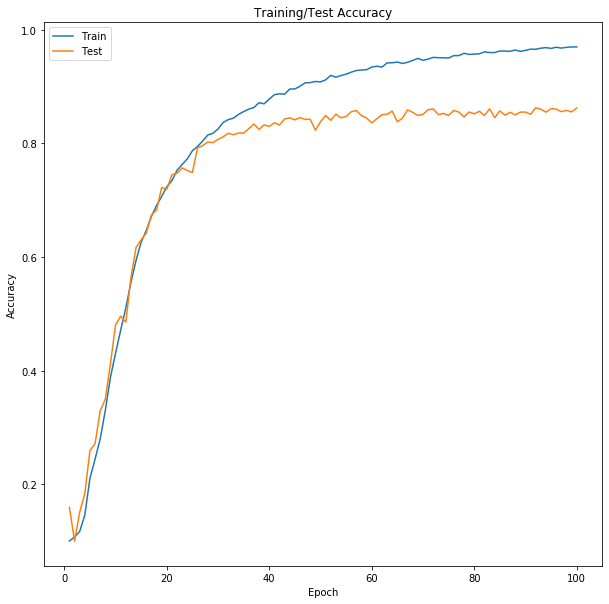

In [218]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.set_title("Training/Test Accuracy")
ax.set_ylabel("Accuracy")
ax.set_xlabel("Epoch")
ax.plot(range(1, len(train_acc_list)+1), train_acc_list)
ax.plot(range(1, len(test_acc_list)+1), test_acc_list)
ax.legend(['Train', 'Test'])
plt.show()

In [221]:
torch.save({
            'epoch': training_epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss,
            'train_accuracy': train_acc_list,
            'test_accuracy' : test_acc_list
            }, '../save/VGG11_default_checkpoint.pt')

In [222]:
ck = torch.load('../save/VGG11_default_checkpoint.pt')

In [224]:
ck['test_accuracy'][99]

tensor(0.8621, device='cuda:0')